Title: **Innovation or Inequality: Do Patent Litigations Lead to Exacerbated Wealth Inequality?**

Section - 1: Introduction




Section - 2: Data Cleaning and Loading

In [404]:
#importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [405]:
#Loading CSV files

#assigned data set: Patent Litigations
cases = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/cases.csv")

#y-variable from extternal sourc:e
gini = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/Gini.csv")

#3 new x-variables from external soruces:
urbanization = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/urbanization_rate.csv", on_bad_lines='skip')
unemployment = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/US-Unemployment.csv", on_bad_lines='skip')
inflation= pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/inflation.csv", header=0,on_bad_lines='skip')

In [406]:
#isolating relevant variables from the raw litigations data
clean_cases = cases[['case_row_id', 'case_number', 'case_cause', 'date_filed', 'date_closed']]
clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


#aggregating cases filed/closed by year
cases_closed = clean_cases.groupby('year_closed')['case_number'].nunique().reset_index()
cases_closed.columns = ['year', 'cases_closed']
cases_filed = clean_cases.groupby('year_filed')['case_number'].nunique().reset_index()
cases_filed.columns = ['year', 'cases_filed']

#new df containing total cases filed/closed in a given year
annual_cases = pd.merge(cases_filed, cases_closed, on='year', how='outer').fillna(0)
annual_cases[['cases_filed', 'cases_closed']] = annual_cases[['cases_filed', 'cases_closed']].astype(float)
annual_cases['year'] = annual_cases['year'].astype(int)

#cleaning unemployment df and computing avg annual unemployment rates for the US
unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int)
clean_unemployment = pd.DataFrame()
clean_unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int).unique()
clean_unemployment['unemployment_rate'] = (unemployment.groupby(unemployment['observation_date'].str[0:4].astype(int))['UNRATE'].mean().values)

#isolating annual gini coeff data for the US
clean_gini = pd.DataFrame()
clean_gini['year'] = gini['observation_date'].str[0:4].astype(int)
clean_gini['gini'] = gini['SIPOVGINIUSA']

#converting year columns to rows in clean_urbanization df
clean_urbanization = urbanization.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Urban Rate')

clean_urbanization['year'] = pd.to_numeric(clean_urbanization['year'], errors='coerce')
clean_urbanization = clean_urbanization.dropna(subset=['year'])
clean_urbanization['year'] = clean_urbanization['year'].astype(int)
#isolating US data
clean_urbanization = clean_urbanization[clean_urbanization['Country Name'] == 'United States']
clean_urbanization = clean_urbanization.drop(columns=['Country Name'])
clean_urbanization = clean_urbanization.reset_index()


#converting year columns to rows in clean_inflation df
clean_inflation = inflation.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Inflation Rate')

clean_inflation['year'] = pd.to_numeric(clean_inflation['year'], errors='coerce')
clean_inflation = clean_inflation.dropna(subset=['year'])
clean_inflation['year'] = clean_inflation['year'].astype(int)
#isolating US data
clean_inflation = clean_inflation[clean_inflation['Country Name'] == 'United States']
clean_inflation = clean_inflation.drop(columns=['Country Name'])
clean_inflation = clean_inflation.reset_index()

<ipython-input-406-085719f863e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
<ipython-input-406-085719f863e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


In [407]:
#merging all variables into one df
complete_merged = pd.DataFrame()
complete_merged = pd.merge(clean_gini, annual_cases, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_urbanization, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_unemployment, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_inflation, on='year', how='inner')
complete_merged = complete_merged.drop(columns=['index_x'])
complete_merged = complete_merged.drop(columns=['index_y'])

In [408]:
complete_merged.head()

,year,gini,cases_filed,cases_closed,Urban Rate,unemployment_rate,Inflation Rate
0,1963,37.6,1.0,1.0,71.134,5.641667,1.239669
1,1972,36.7,4.0,1.0,73.623,5.600000,3.272278
2,1973,36.1,0.0,1.0,73.633,4.858333,6.17776
3,1974,35.5,2.0,2.0,73.643,5.641667,11.054805
4,1975,35.6,4.0,2.0,73.653,8.475000,9.143147


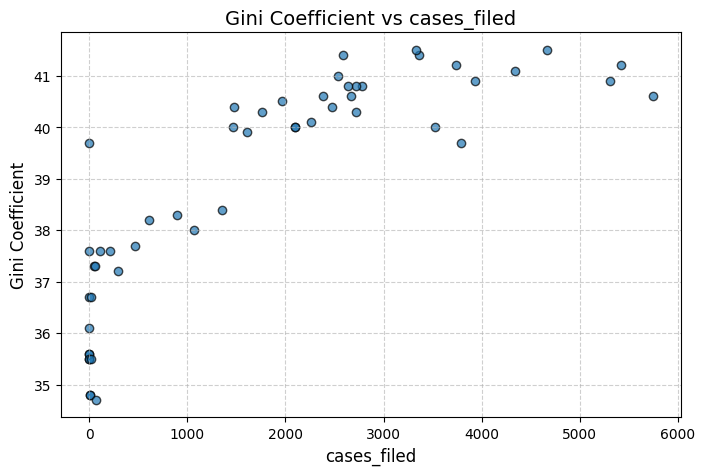

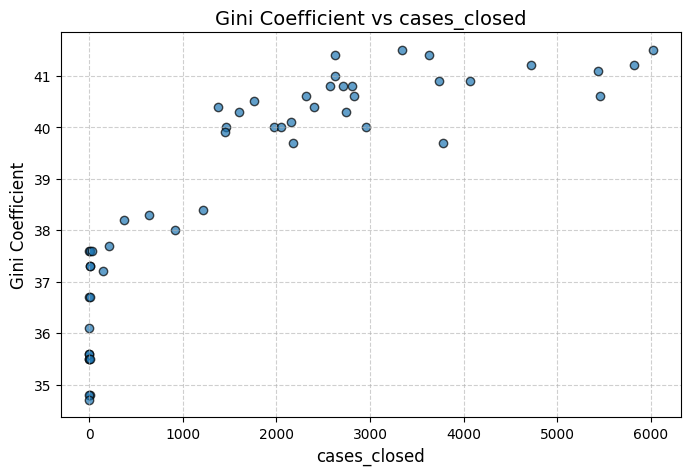

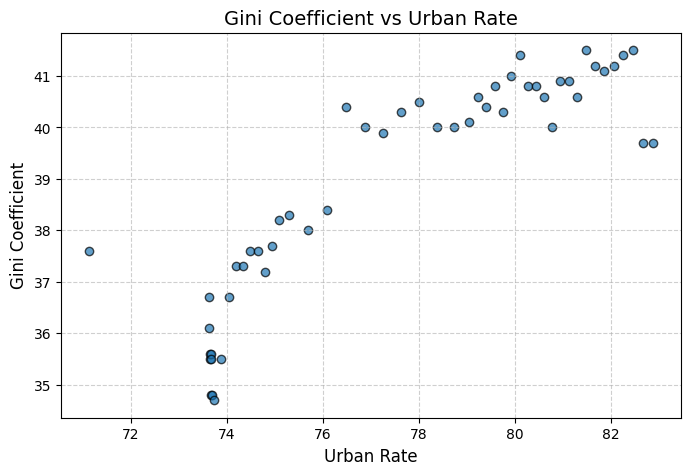

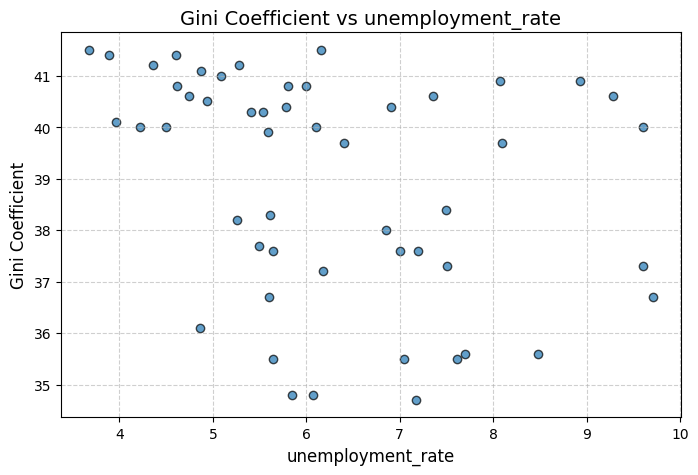

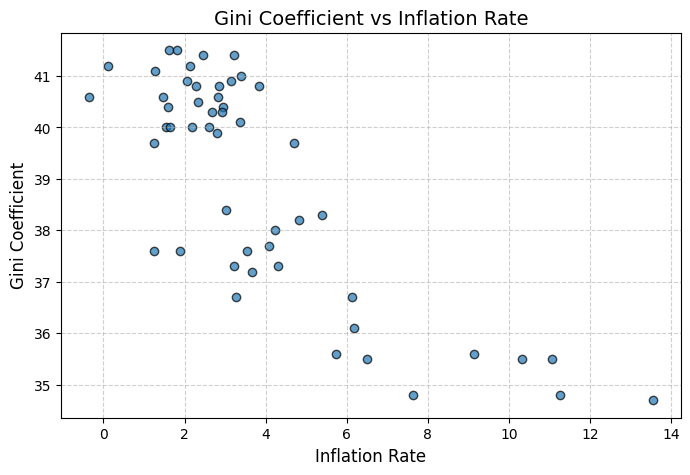

In [409]:
x_vars = ['cases_filed', 'cases_closed', 'Urban Rate', 'unemployment_rate', 'Inflation Rate']

# Loop through each variable and create a scatter plot with Gini
for x in x_vars:
    plt.figure(figsize=(8, 5))
    plt.scatter(complete_merged[x], complete_merged['gini'], alpha=0.7, edgecolor='k')
    plt.title(f'Gini Coefficient vs {x}', fontsize=14)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('Gini Coefficient', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()